# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Imports here

#All the necessary packages and modules are imported in the first cell of the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import json
import numpy as np
from collections import OrderedDict
import time
import copy

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler

from PIL import Image

import seaborn as sns

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

#Create a dictionary of the data directories
dirs = {
    'train': train_dir,
    'valid': valid_dir,
    'test': test_dir
}


In [5]:
# TODO: Define your transforms for the training, validation, and testing sets

#torchvision transforms are used to augment the training data with random scaling, rotations, mirroring, and/or cropping
#The training, validation, and testing data is appropriately cropped and normalized

#Create a dictionary for the transforms.
data_transforms = {
    #Transform for training data, Random rotate, resize, crop, flip, convert to tensor, then normalize.
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    #Valid and Test data, just reize, centercrop, convert to tensor, and normalize.
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    
}

# TODO: Load the datasets with ImageFolder

#The data for each set (train, validation, test) is loaded with torchvision's ImageFolder
image_datasets = {key: datasets.ImageFolder(dirs[key], data_transforms[key]) for key in dirs}


# TODO: Using the image datasets and the trainforms, define the dataloaders
#The data for each set is loaded with torchvision's DataLoader
dataloaders = {key: torch.utils.data.DataLoader(image_datasets[key], batch_size=64, shuffle=True) for key in dirs}

#Calculate the size of the datasets for later use.
dataset_sizes = {key: len(image_datasets[key]) for key in dirs}

#Get the index to class map from the training set.
class_names = image_datasets['train'].classes

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
#Load the JSON file with the category names
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)



# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [7]:
# TODO: Build and train your network

#Hard code variables for use in part 2
hidden_units = 4096
learning_rate = 0.001
num_epochs = 1
device = 'cuda'

#A pretrained network such as VGG16 is loaded from torchvision.models and the parameters are frozen
model = models.vgg19(pretrained=True)

#A new feedforward network is defined for use as a classifier using the features as input
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, hidden_units)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(hidden_units, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

#The parameters of the feedforward classifier are appropriately trained, while the parameters of the feature network are left static
for param in model.parameters():
    param.requires_grad = False

#Configure new classifier, criterion, optimizer, and scheduler.
model.classifier = classifier

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\dkelly/.torch\models\vgg19-dcbb9e9d.pth
100.0%


In [8]:
def train_model(model, criterion, optimizer, scheduler, device, num_epochs=25):
    #Begin tracking time
    start_time = time.time()
    #move model to correct device (GPU or CPU)
    model.to(device)
    #Set best epoch accuracy to 0
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                # if training put model in training mode
                model.train()  
            else:
                #If validating put model in evaluation mode for performance
                model.eval()
                
            #Reset the stats for each epoch
            running_loss = 0.0
            running_corrects = 0

            #Load batch data from dataloader
            for inputs, labels in dataloaders[phase]:
                #Move data to correct device (GPU or CPU)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #Reset gradients to 0
                optimizer.zero_grad()

                #Enable or disable gradient calcualtions depending on doing training or validation
                with torch.set_grad_enabled(phase == 'train'):
                    #Get Preditictions and loss
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #Backpropagate loss and step the optimizer if training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #Calculate epoch stats for loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #During training, the validation loss and accuracy are displayed            
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #If the current epoch is more accurate than any previous ones, save the weights.
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    #Calculate and print training time
    total_time = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))
    print('Best Accuracy: {:4f}'.format(best_acc))
    
    #Take the weights from the most accurate epoch and save them to the model.
    model.load_state_dict(best_model_wts)
    
    return model

In [7]:
trained_model = train_model(model, criterion, optimizer, scheduler, device, num_epochs)

Epoch 1/1
train Loss: 2.7614 Acc: 0.4495
valid Loss: 0.8728 Acc: 0.7531
Training complete in 3m 26s
Best Accuracy: 0.753056


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

## Testing your network
It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# TODO: Do validation on the test set
def test_model(model, data_set, device):
    #Model to evaluation mode to improve performance
    model.eval()

    #Move model to correct device (GPU or CPU)
    model.to(device)
    
    running_corrects = 0
    
    #Load the data for the test set
    for inputs,labels in dataloaders[data_set]:
        #make sure the data is configure for the correct device (GPU/CPU)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #Don't need gradient calcs
        with torch.no_grad():
            #Get predictions
            outputs = model.forward(inputs)
            _, preds = torch.max(outputs, 1)
            
        #Calculate & print accuracy
        running_corrects += torch.sum(preds == labels.data)
    total_accuracy = running_corrects.double() / dataset_sizes[data_set]
    #The network's accuracy is measured on the test data
    print('Accuracy {:.4f}'.format(total_accuracy))
    
    return None
    

In [18]:
test_model(trained_model,'test', device)

NameError: name 'trained_model' is not defined

In [ ]:

model.class_to_idx = image_datasets['train'].class_to_idx
model.hidden_units = hidden_units
model.to('cpu')

#The trained model is saved as a checkpoint along with associated hyperparameters and the class_to_idx dictionary

#Save parameters to re-build model later
torch.save({
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx,
    'hidden_units': model.hidden_units
}, 'checkpoint.pth')


In [21]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

#There is a function that successfully loads a checkpoint and rebuilds the model
def load_model(checkpoint_path, device):
    #Load the saved checkpoint from the specified path, and map it to the correct device (GPU/CPU)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model = models.vgg19(pretrained=True)
    #Freeze the parameters of the pre-trained model.
    for param in model.parameters():
        param.requires_grad = False
        
    #Load the class map from the checkpoint to the model.    
    model.class_to_idx = checkpoint['class_to_idx']
    
    #Build the classifier with the correct # of input, hidden, and output units.
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(25088, checkpoint['hidden_units'])),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(checkpoint['hidden_units'], 102)),
        ('output', nn.LogSoftmax(dim=1))
        ]))
    #Set the model classifier to the custom classifier created above
    model.classifier = classifier
    
    #Load the state dict of the checkpoint to the model
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [22]:
trained_model = load_model('checkpoint.pth','cpu')

#test_model(trained_model, 'test','cpu')


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
 #The process_image function successfully converts a PIL image into an object that can be used as input to a trained model

    # TODO: Process a PIL image for use in a PyTorch model
    #Open the image specified in the path
    image = Image.open(image)
    
    #Get the width and height of the image
    width, height = image.size
    
    #print('Beginning image size width: {} height:{} aspect ratio {:.2f}'.format(width, height ,width/height )) 
    
    #Resize Image shortest side is 256 maintain aspect ratio
    if width < height:
        #short width
        pct = (256/float(width))
        size = int(float((height)*float(pct)))
        image = image.resize((256,size), Image.ANTIALIAS)
    else:
        #short height
        pct = (256/float(height))
        size = int(float((width)*float(pct)))
        image = image.resize((size,256), Image.ANTIALIAS)
        
    #Get the new width and height of the image
    width, height = image.size
    #print('New image size width: {} height:{} aspect ratio {:.2f}'.format(width, height, width/height))
    
    #Center crop 224x224 pixels
    l = (width - 224)/2
    t = (height - 224)/2
    r = (width + 224)/2
    b = (height + 224)/2
    image = image.crop((l, t, r, b))
    
    #convert to np.array
    image = np.array(image)/255    
    
    #normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean)/std
    image = image.transpose(2,0,1)
    
    return image


In [24]:
process_image('flowers/test/1/image_06743.jpg')

array([[[-1.77540885, -1.74115935, -1.72403459, ..., -2.03228016,
         -1.96378115, -1.94665639],
        [-1.33016525, -1.26166624, -1.46716328, ..., -1.99803065,
         -1.9809059 , -1.96378115],
        [-1.84390787, -1.86103262, -1.84390787, ..., -1.94665639,
         -1.96378115, -1.96378115],
        ..., 
        [-1.51853755, -1.58703656, -1.60416132, ..., -1.22741673,
         -1.48428804, -1.29591575],
        [-1.56991181, -1.60416132, -1.58703656, ..., -1.48428804,
         -1.5356623 , -1.21029198],
        [-1.82678311, -1.70690984, -1.65553558, ..., -2.06652967,
         -1.39866427, -1.0904187 ]],

       [[-1.4754902 , -1.44047619, -1.42296919, ..., -1.93067227,
         -1.89565826, -1.86064426],
        [-1.05532213, -1.00280112, -1.21288515, ..., -1.87815126,
         -1.87815126, -1.86064426],
        [-1.65056022, -1.65056022, -1.63305322, ..., -1.80812325,
         -1.79061625, -1.79061625],
        ..., 
        [-1.17787115, -1.17787115, -1.17787115, ...,

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [25]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if title:
        plt.title(title)
        
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

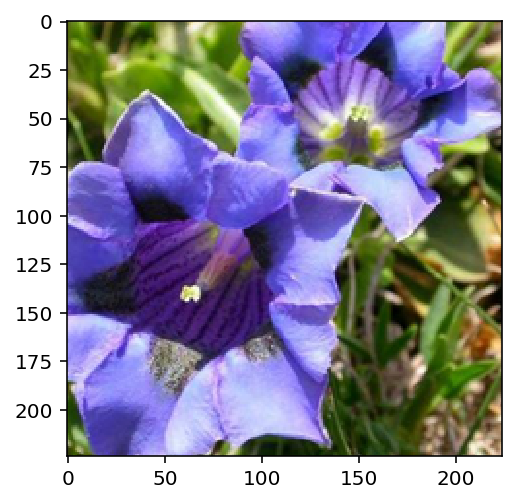

In [26]:
processed_image = process_image('flowers/test/28/image_05230.jpg')

imshow(processed_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [58]:
def predict(image_path, model, device, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = process_image(image_path)
#The predict function successfully takes the path to an image and a checkpoint, then returns the top K most probably classes for that image  
    # TODO: Implement the code to predict the class from an image file
    #Set the model to evaluation mode to improve performance
    model.eval()
    #Make sure the model is using the correct device (CPU/GPU)
    model.to(device)
    
    #Convert the image from a Numpy array to a tensor
    image = torch.from_numpy(image).type(torch.FloatTensor)
    #Add a dimension to the beginning of the tensor to account for expected dimension for batch size.
    image = image.unsqueeze(0)
    #Move image to correct device (GPU/CPU)
    image = image.to(device)
    
    #Get the predicted probabilities
    probs = torch.exp(model.forward(image))
    
    #Get the TopK probabilities and labels from the prediction
    topk_probs, topk_labels = probs.topk(topk)
    
     #Move Probs and Lables to CPU so that they can be converted to numpy arrays then lists for displaying and pulling the flower names.
    topk_probs = topk_probs.to('cpu')
    topk_labels = topk_labels.to('cpu')
    topk_probs = topk_probs.detach().numpy().tolist()[0]
    topk_labels = topk_labels.detach().numpy().tolist()[0]
    
    #Create a dictionary for the class to model output index mappings from the model.
    idx_to_class = {val: key for key , val in model.class_to_idx.items()}
    
    #Get the topk classes from the predicted labels
    top_labels = [idx_to_class[label] for label in topk_labels]
    
    #Get the actual flower names based on the top labels and index_to_class dictionary from the JSON file
    flower_names = [cat_to_name[idx_to_class[label]] for label in topk_labels]
    
    return topk_probs, topk_labels, flower_names

In [59]:
image_path = 'flowers/test/28/image_05230.jpg'
device = 'cpu'

predict(image_path, trained_model, device, 5)

([0.554375946521759,
  0.11362332850694656,
  0.0978202372789383,
  0.09448765963315964,
  0.08691786229610443],
 [91, 25, 66, 85, 36],
 ['monkshood', 'canterbury bells', 'spring crocus', 'columbine', 'sweet pea'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [54]:
# TODO: Display an image along with the top 5 classes

def sanity_check(image_path, model, device, topk):

    #A matplotlib figure is created displaying an image and its associated top 5 most probable classes with actual flower names    
    image = process_image(image_path)
    topk_probs, topk_labels, flower_names = predict(image_path, model, device, topk)
    
    #4 x 6 inch figure
    plt.figure(figsize=(4,6))
    #2 rows, 1 column, first cell
    ax = plt.subplot(2,1,1)
    #Get the actual flower label from the filename
    actual_label = image_path.split('/')[2]
    #Title the plot after the actual flowername.
    plot_title = cat_to_name[actual_label]
    #Show the flower image
    imshow(image, ax, plot_title);
    
    #second cell in plot
    plt.subplot(2,1,2)
    #Seaborn barplot x is probabilities, y axis is names. default colour
    sns.barplot(x=topk_probs, y=flower_names, color=sns.color_palette()[0]);
    
    #fit plots to figure area
    plt.tight_layout()
    
    plt.show()


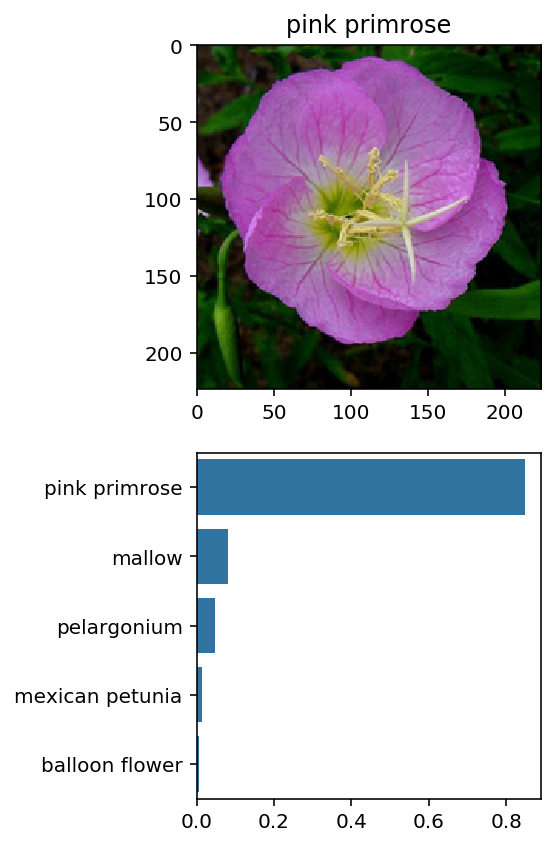

In [57]:
image_path = 'flowers/test/1/image_06764.jpg'
device= 'cpu'
topk = 5
sanity_check(image_path, trained_model, device, topk)